-What about electrons? (I don't see any - 2 phys.me)

-1e11 and mDM?

-Compute T(E,z_in, z_dep) by doing a delta function injection

# Full Transfer Functions

In [ ]:
%load_ext autoreload
# %load_ext line_profiler
import sys
sys.path.append("..")

In [62]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [15,15]


from astropy.io import fits

import numpy as np
from numpy.linalg import matrix_power
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_spectrum import nonrel_spec
from darkhistory.electrons.ics.ics_spectrum import rel_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.electrons import positronium as pos

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In [7]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

## Photon Transfer Functions

In [193]:
user = '/home/gridgway'

highengphot_tflist_arr = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [194]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [195]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


## Inverse Compton Scattering

Set up all of the inverse Compton scattering transfer functions (needs to be hidden away at some point). 

In [8]:
# %%prun

Emax = 1e20
Emin = 1e-8
nEe = 5000
nEp  = 5000

dlnEp = np.log(Emax/Emin)/nEp
lowengEp_rel = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_rel = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

Emax = 1e10
Emin = 1e-8
nEe = 5000
nEp  = 5000

dlnEp = np.log(Emax/Emin)/nEp
lowengEp_nonrel = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)  

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_nonrel = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

print('********* Thomson regime scattered photon spectrum *********')
ics_thomson_ref_tf = nonrel_spec(lowengEe_nonrel, lowengEp_nonrel, phys.TCMB(400))
print('********* Relativistic regime scattered photon spectrum *********')
ics_rel_ref_tf = rel_spec(lowengEe_rel, lowengEp_rel, phys.TCMB(400), inf_upp_bound=True)
print('********* Thomson regime energy loss spectrum *********')
engloss_ref_tf = engloss_spec(lowengEe_nonrel, lowengEp_nonrel, phys.TCMB(400), nonrel=True)

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...


KeyboardInterrupt: 

In [22]:
pickle.dump(ics_thomson_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ics_thomson_ref_tf.p", "wb"))
pickle.dump(ics_rel_ref_tf,     open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ics_rel_ref_tf.p", "wb"))
pickle.dump(engloss_ref_tf,     open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/engloss_ref_tf.p", "wb"))


In [ ]:
ics_thomson_ref_tf_2 = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/ics_thomson_ref_tf.p", "rb"))
ics_rel_ref_tf_2 = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/ics_rel_ref_tf.p", "rb"))
engloss_ref_tf_2 = pickle.load(open(user+"/Dropbox (MIT)/Photon Deposition/engloss_ref_tf.p", "rb"))


In [24]:
# test = ics_rel_ref_tf_2[20]

In [ ]:
%%prun
start_rs = 3000
rs = start_rs
while rs > 2500:
    (ics_sec_phot_tf, ics_sec_elec_tf, continuum_loss) = get_ics_cooling_tf(
        ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
        eleceng, photeng, rs, fast=True
    )
    rs = np.exp(np.log(rs) - 0.002)
    print(rs)

In [12]:
%lprun -f spectools.engloss_rebin_fast spectools.engloss_rebin_fast(lowengEe_rel,lowengEp_rel,ics_rel_ref_tf_2.grid_vals,lowengEe_rel)

## Evolution

In [187]:
# mDM = 605662.1322589782*2
# mDM = 10**9.104*2
# mDM = 1.27164e9*2
# mDM = 10**12*2
# mDM = 10**6.5*2
mDM = 2*phys.me*1.01

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      photeng)
phot_spec_init.switch_spec_type()

elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
    np.array([mDM/2 - phys.me]),
    eleceng)

elec_spec_init.switch_spec_type()

In [189]:
elec_spec_init.toteng()/2

5109.989461000023

In [190]:
print(phot_spec_init.toteng()/mDM)
print(elec_spec_init.toteng()/mDM + 2*phys.me/mDM)

0.9999999999999998
1.0


In [191]:
%autoreload
phot_spec_init.rs = 3000
elec_spec_init.rs = 3000
end_rs   = 4

sigmav = 1e-26
tau = 1e25

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dE/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dE/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dE/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz*coarsen_factor/phys.hubble(rs)
    
    # Function that changes the normalization from per annihilation to per baryon. 
    def norm_fac(rs): 
        return rate_func_N(rs) * dlnz * coarsen_factor /phys.hubble(rs) / (phys.nB * rs**3)
    
    # ICS for in_spec_elec goes here.
    
    elec_processes = False
    
    if in_spec_elec.totN() > 0:
        elec_processes = True
    
    if elec_processes:
        (ics_sec_phot_tf, ics_sec_elec_tf, continuum_loss) = get_ics_cooling_tf(
            ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
            eleceng, photeng, rs, fast=True
        )

        ics_phot_spec = ics_sec_phot_tf.sum_specs(in_spec_elec)
        ics_lowengelec_spec = ics_sec_elec_tf.sum_specs(in_spec_elec)
        positronium_phot_spec = pos.weighted_photon_spec(photeng)*in_spec_elec.totN()/2
        if positronium_phot_spec.spec_type != 'N':
            positronium_phot_spec.switch_spec_type()
        
#         print('input electron energy: ', (phys.me*2 + in_spec_elec.toteng())*norm_fac(rs))
#         print('ICS secondary photon spectrum energy: ', ics_phot_spec.toteng()*norm_fac(rs))
#         print('Upscattered photon energy: ', np.dot(in_spec_elec.N, continuum_loss)*norm_fac(rs))
#         print('ICS low energy electron spectrum energy: ', (ics_lowengelec_spec.toteng() + phys.me)*norm_fac(rs))
#         print('Positronium spectrum energy: ', positronium_phot_spec.toteng()*norm_fac(rs))
    
        init_inj_spec = (in_spec_phot + ics_phot_spec + positronium_phot_spec)*norm_fac(rs)
    else:
        init_inj_spec = in_spec_phot * norm_fac(rs)
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
#     if std_soln:
    if True:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # For the tqdm bar
    pbar = tqdm(total = np.floor((np.log(rs) - np.log(end_rs))/dlnz/coarsen_factor).astype(int))
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # Update tqdm bar.
        pbar.update(1)
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt, 0
                )  
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt, 0
                )
                
            std_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt, 0
                )
            
            backreaction_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt, 0
                )
            
            f_raw = np.float64(f_raw)
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])

            new_vals = tla.get_history(
                init_cond, f_raw[0], f_raw[2], f_raw[3], 
                rate_func_eng, np.array([prev_rs, rs]),
                reion_switch = False
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        print('Standard x_e at '+str(rs)+': '+str(xe_std(rs)))
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('Standard T_m at '+str(rs)+': '+str(T_m_std(rs)))
        if prev_rs is not None:
            print('Back Reaction f_ionH, f_ionHe, f_exc, f_heat, f_cont: ', backreaction_f)
            print('Standard f_ionH, f_ionHe, f_exc, f_heat, f_cont: ', std_f)
            
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
        if coarsen_factor > 1:
            prop_tf = np.zeros_like(highengphot_tf._grid_vals)
            for i in np.arange(coarsen_factor):
                prop_tf += matrix_power(highengphot_tf._grid_vals, i)
            lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
            lowengelec_tf._grid_vals = np.matmul(prop_tf, lowengelec_tf._grid_vals)
            highengphot_tf._grid_vals = matrix_power(
                highengphot_tf._grid_vals, coarsen_factor
            )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])

        if elec_processes:
            next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1]) + ics_lowengelec_spec*norm_fac(rs)
        else:
            next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002*coarsen_factor)
        
        dt = dlnz*coarsen_factor/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
    
        if elec_processes:
            (ics_sec_phot_tf, ics_sec_elec_tf, continuum_loss) = get_ics_cooling_tf(
                ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
                eleceng, photeng, rs, fast=True
            )

            ics_phot_spec = ics_sec_phot_tf.sum_specs(in_spec_elec)
            ics_lowengelec_spec = ics_sec_elec_tf.sum_specs(in_spec_elec)

            next_inj_spec = (in_spec_phot + ics_phot_spec + positronium_phot_spec)*norm_fac(rs)
    
        else:
            next_inj_spec = in_spec_phot * norm_fac(rs)
        

        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        print('************************ END OF LOOP **************************')
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )

In [192]:
%%prun
# a = evolve(
#         phot_spec_init*0, phot_spec_init, 
#         rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
#         highengphot_tf_interp, lowengphot_tf_interp, 
#         lowengelec_tf_interp, 
#         end_rs, coarsen_factor=1, std_soln=False
#     )

b_t = evolve(
        elec_spec_init, phot_spec_init*0, 
        rate_func_decay_N, rate_func_decay_eng, xe_std(phot_spec_init.rs), phys.TCMB(phot_spec_init.rs),
        #rate_func_decay_N, rate_func_decay_eng, 2e-4, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

TypeError: weight must be an ndarray or spectrum.

In [ ]:
plt.figure()
# plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
# plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [ ]:
test_tf = highengphot_tf_interp.get_tf(4, xe_std(3000))
highengphot_tf_interp.xe

In [ ]:
plt.figure()

ax = plt.gca()

print(test_tf.in_eng[375])

test_tf.plot(ax, ind=250, indtype='ind')
test_tf.plot(ax, ind=377, indtype='ind')


ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

In [ ]:
test_spectra = highengphot_tf_interp._grid_vals[-1,-1,:,:]

plt.figure()
ax = plt.gca()

plt.plot(highengphot_tf_interp.eng, test_spectra[370, :])

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

In [ ]:
tf_before_interp = highengphot_tflist_arr[-1][-1]
tf_before_interp_2 = highengphot_tflist_arr[-1][0]

# print(tf_before_interp.in_eng[376])

plt.figure()
ax = plt.gca()
# tf_before_interp.plot(ax, ind=200, indtype='ind')
tf_before_interp.plot(ax, ind=370, indtype='ind')
# tf_before_interp_2.plot(ax, ind=376, indtype='ind')


ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

In [ ]:
lowengphot_spectra = b[3]
print(lowengphot_spectra.in_eng)

lowengphot_spectra *= (rate_func_decay_N(3000) * (0.002/phys.hubble(3000)) / (phys.nB * 3000**3))**(-1)

print(lowengphot_spectra[0].toteng())

plt.figure()
ax = plt.gca()

lowengphot_spectra.switch_spec_type()
lowengphot_spectra.plot(ax, ind=0, indtype='ind')
lowengphot_spectra.switch_spec_type()

ax.set_xscale('log')
ax.set_yscale('log')

plt.axis([1e-4, 1e3, 1e-10, 1e6])

In [ ]:
lowengelec_spectra = b[4]

lowengelec_spectra *= (rate_func_decay_N(3000) * (0.002/phys.hubble(3000)) / (phys.nB * 3000**3))**(-1)

print(lowengelec_spectra[0].toteng())
utils.compare_arr([lowengelec_spectra[0].eng, lowengelec_spectra[0].dNdE])

plt.figure()
ax = plt.gca()

lowengelec_spectra.switch_spec_type()
lowengelec_spectra.plot(ax, ind=0, indtype='ind')
lowengelec_spectra.switch_spec_type()

ax.set_xscale('log')
ax.set_yscale('log')

plt.axis([1, 3e3, 1e-4, 1e3])

In [ ]:
highengphot_spectra = b[2]

highengphot_spectra *= (rate_func_decay_N(3000) * (0.002/phys.hubble(3000)) / (phys.nB * 3000**3))**(-1)

print(2*10**9.104)
print(highengphot_spectra[0].toteng())
print(highengphot_spectra[1].toteng())

plt.figure()
ax = plt.gca()

highengphot_spectra.switch_spec_type()
highengphot_spectra.plot(ax, ind=1, indtype='ind')
highengphot_spectra.switch_spec_type()

ax.set_xscale('log')
ax.set_yscale('log')

plt.axis([1e-4,5e12, 1e-40, 1e10])

In [99]:
f_decay_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "rb"))
f_decay_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
f_swave_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "rb"))
f_swave_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "rb"))

In [29]:
user='/home/gridgway'
fz_phot_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]

In [177]:
def get_fcontour(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec
            eng=10**log10eng[10:]/2-phys.me
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec
            eng=10**log10eng[9:-2]-phys.me
            folder='elec_swave/'
    else:
        coarsen_factor = 4

        if inj_type is 'decay':
            f_for_plot = f_decay_phot
            eng=10**log10eng/2
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot
            eng=10**log10eng[:-2]
            folder='phot_swave/'

    rs_list = [3000*np.exp(-0.002*coarsen_factor*(i+1)) for i in np.arange(3200/coarsen_factor-1)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])

    cs = ax.contourf(eng,rs_list,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels,
                     cmap=cm.RdBu_r)
#     ax.contour(eng,rs_list,
#                np.transpose(f_for_plot[:,:,ind]),  
#                levels=levels,
#                colors='k'
#               )
    cbar = plt.colorbar(cs)

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     user='gridgway'
#     plt.savefig(
#         '/home/gridgway/Dropbox (MIT)/Photon Deposition/plots/f_contours/'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )

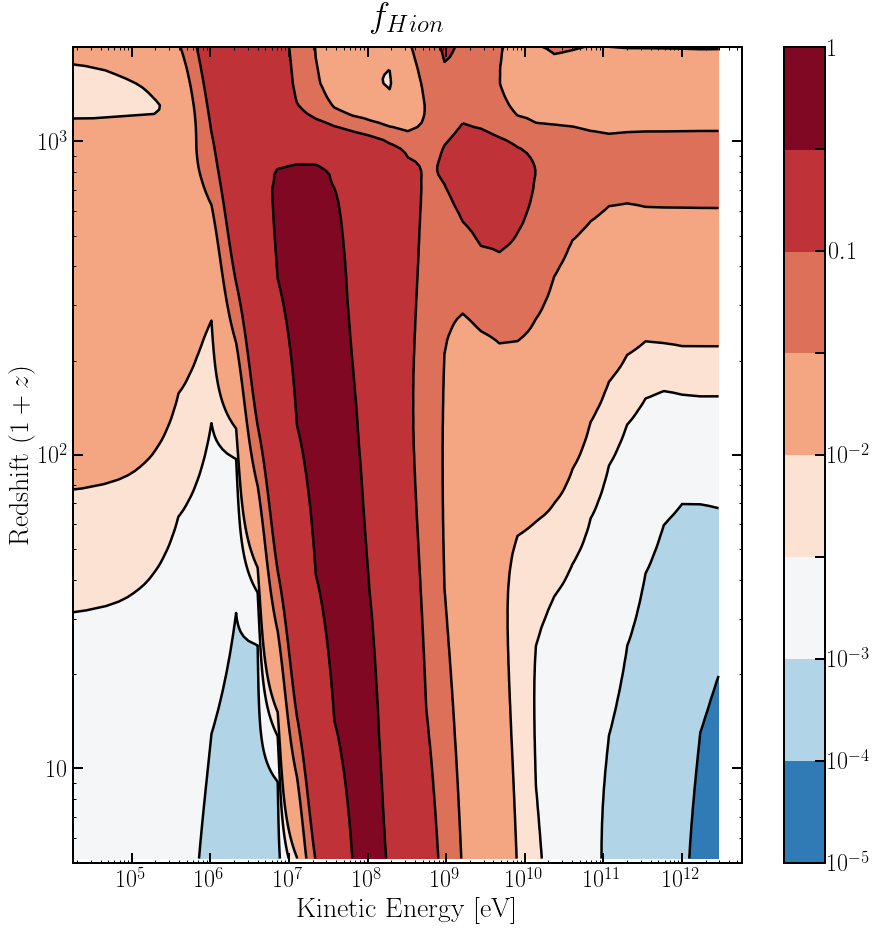

In [178]:
get_fcontour('decay','elec','H_ion')